## Predict if a passenger survived or not

In [2]:
import sys
sys.path.append('C:\\Users\\PAT\\Documents\\edwisor\\projects\\Titanic')
from Titanic import *
from Titanic.config import *

In [3]:
data = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
full_data = [data,test]

In [243]:
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [66]:
data.shape

(891, 12)

In [96]:
test.shape

(418, 11)

In [67]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [85]:
def get_col_names():
    continous_names = []
    categ_names = []
    for i in data.columns:
        continous_names.append(i) if data.loc[:,i].dtypes in ['int64','int32','float32','float64'] \
        else categ_names.append(i)
    return continous_names,categ_names

In [150]:
#iloc used for col index and loc for col name
continous_names, cat_names = get_col_names()
print('-----Summary of columns')
print('Total col -',data.shape[1] )
print('continous are -', len(continous_names))
print(data[continous_names].head(1))
print('-----')
print('categorical are -', len(cat_names))
print(data[cat_names].head(1))

-----Summary of columns
Total col - 12
continous are - 7
   PassengerId  Survived  Pclass   Age  SibSp  Parch  Fare
0            1         0       3  22.0      1      0  7.25
-----
categorical are - 5
                      Name   Sex     Ticket Cabin Embarked
0  Braund, Mr. Owen Harris  male  A/5 21171   NaN        S


## Missing value analysis


In [21]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Missing value percentages

In [308]:
#get the rows with null values
missing_values = pd.DataFrame(data.isnull().sum())
#rename the columns old value: 0, new_value:'missing_per'
missing_values = missing_values.rename(columns = {'index':'variable', 0:'missing_per'})
missing_values['missing_per'] = (missing_values['missing_per']/len(data))*100
missing_values

,missing_per
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.865320
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


## FINDING: If missing value is >30 %, we can ignore that field
    Drop Cabin
    

In [151]:
#bk_full_data = full_data
for i,dataset in enumerate(full_data):
    
    
    dataset = dataset.drop(['Cabin','PassengerId'],axis=1)
    #print(dataset.head(1))
    dataset['family_size'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset = dataset.drop(['SibSp', 'Parch'], axis = 1)
    dataset['is_alone'] = 0 #Initialize value of this var/col
    dataset.loc[dataset['family_size'] ==1 , 'is_alone'] = 1 #set to 1/True if family size is 1 or else 0(intialize value)
    dataset['is_alone'] = dataset['is_alone'].astype('object')
    if i == 0:#update the original df 
        data = dataset 
    else:
        test = dataset
#update continous variables also, since these col are already dropped
continous_names.append('family_size')
continous_names.remove('PassengerId')
continous_names = [ x for x in continous_names if x not in ['SibSp', 'Parch']]
cat_names.remove('Cabin')
cat_names.append('is_alone')


full_data = [data,test]#Update the list

In [153]:
data.head(1),data.shape

(   Survived  Pclass                     Name   Sex   Age     Ticket  Fare  \
 0         0       3  Braund, Mr. Owen Harris  male  22.0  A/5 21171  7.25   
 
   Embarked  family_size is_alone  
 0        S            2        0  , (891, 10))

In [154]:
#Let us take a subset of valid dataset and compute if mean, median or knnimpute fits the best
#get data for which age is not null
data[data['Age'].isnull() == False].head(2)

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,family_size,is_alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,2,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,2,0


## Choose mean or median?
#data.iloc[1]['Age'] = 38.0

-----------Now set set to null
data['Age'].loc[1] = np.nan


#mean = 29.68 data['Age'].mean()
#median = 28 data['Age'].median()
## FINDING:
    Choose mean as it is giving the closest value

In [155]:
for i,dataset in enumerate(full_data):
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].mean())
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mean())
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
    if i == 0:
        data = dataset
    else:
        test = dataset
full_data = [data,test]

In [156]:
data.isnull().sum()
#bk_data = data

Survived       0
Pclass         0
Name           0
Sex            0
Age            0
Ticket         0
Fare           0
Embarked       0
family_size    0
is_alone       0
dtype: int64

## Outlier analysis for continous variables

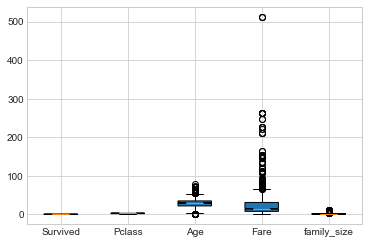

In [157]:
plot = []
for i in continous_names:
    #plt.boxplot(train_df.iloc[:,i])
    plot.append(list(data.loc[:,i]))
#plot = [list(train_df.loc[:,'Item_Weight']), list(train_df.loc[:,'Item_MRP'])]
plt.boxplot(plot, notch = 'True', patch_artist= True, labels=continous_names)
plt.show()

## FINDING: 
A lot of outliers in age, fare..Lets remove those

In [160]:
#data = full_data[0]
for i in continous_names:
    q75,q25 = np.percentile(data.loc[:,i],[75,25])
    iqr = q75 - q25
    min = q25 - (iqr* 1.5)#lower fence
    max = q25 + (iqr* 1.5)#upper fence
    #if train_df.loc[:,i] < min:
    
    print('-----Thes will be droppped for col :',i,'\n',data[data.loc[:,i] >max].head())
    print(min,max)
    data = data.drop(data[data.loc[:,i] <min].index)
    data = data.drop(data[data.loc[:,i] > max].index)
    test = test.drop(data[data.loc[:,i] <min].index)
    test = test.drop(data[data.loc[:,i] > max].index)

-----Thes will be droppped for col : Survived 
 Empty DataFrame
Columns: [Survived, Pclass, Name, Sex, Age, Ticket, Fare, Embarked, family_size, is_alone]
Index: []
-1.5 1.5
-----Thes will be droppped for col : Pclass 
 Empty DataFrame
Columns: [Survived, Pclass, Name, Sex, Age, Ticket, Fare, Embarked, family_size, is_alone]
Index: []
0.5 3.5
-----Thes will be droppped for col : Age 
     Survived  Pclass                              Name     Sex   Age  \
6          0       1           McCarthy, Mr. Timothy J    male  54.0   
11         1       1          Bonnell, Miss. Elizabeth  female  58.0   
15         1       2  Hewlett, Mrs. (Mary D Kingcome)   female  55.0   
33         0       2             Wheadon, Mr. Edward H    male  66.0   
35         0       1    Holverson, Mr. Alexander Oskar    male  42.0   

        Ticket     Fare Embarked  family_size is_alone  
6        17463  51.8625        S            1        1  
11      113783  26.5500        S            1        1  
15      

In [163]:
full_data=[data,test]
data.shape,test.shape


((484, 10), (418, 9))

## chi-square analysis for categorical
#Hypothesis H0(NUll hypothesis)- Relation b/w all IV variable(seperately) and dependent(outlet_sales) is said to be independent of each other
#H1- says that the Relation b/w all IV variable(seperately) and dependent(outlet_sales) is said to be dependent on each other
#if p-val>0.05 the H0 is accepted, signifiying that there is no significant relation and they are independent and hence we can drop that var
#if p-val <0.05 H0 is rejected and H1 is accepted and we can include the var, since
#they are dependent and can explain the DV significantly

In [164]:
#bk_data = data
#data = bk_data
skip_list = []
for i in cat_names:
    chi2, p, dof,ex = chi2_contingency(pd.crosstab(data['Survived'], data[i]))
    if(p<0.05):#H1 accepted
        print('accept -pvalue %f %s'%(p,i))
        
    else:
        print('skip -p value %f %s'%(p,i))
        skip_list.append(i)
data = data.drop(skip_list,axis=1)
test = test.drop(skip_list,axis=1)

#Remove irrelevant categorical variables
cat_names = [ x for x in cat_names if x not in skip_list]

skip -p value 0.478627 Name
accept -pvalue 0.000000 Sex
skip -p value 0.474724 Ticket
accept -pvalue 0.008503 Embarked
accept -pvalue 0.005298 is_alone


In [165]:
full_data = [data,test]#Update the list
data.shape, test.shape

((484, 8), (418, 7))

In [166]:
data.describe()

,Survived,Pclass,Age,Fare,family_size
count,484.000000,484.000000,484.000000,484.000000,484.000000
mean,0.293388,2.628099,27.146238,11.697089,1.163223
std,0.455786,0.618985,6.271089,7.044375,0.369952
min,0.000000,1.000000,4.000000,0.000000,1.000000
25%,0.000000,2.000000,22.000000,7.750000,1.000000
50%,0.000000,3.000000,29.699118,8.050000,1.000000
75%,1.000000,3.000000,29.699118,13.000000,1.000000
max,1.000000,3.000000,41.000000,35.500000,2.000000


## FINDING
min Fare says 0


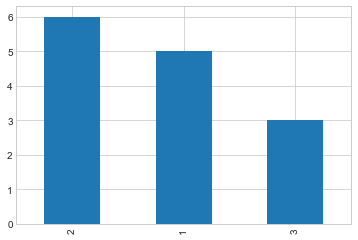

In [167]:
data[data['Fare']==0].Pclass.value_counts().plot.bar()

## FINDING
Either Class 2 dint pay prices or its just missing :)

In [168]:
for dataset in full_data:
    #fare is in floating values, lets map to categories(see categorical_fare for binning ranges),but still int
    dataset.loc[dataset['Fare'] <= 7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.54),'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    #same with age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 

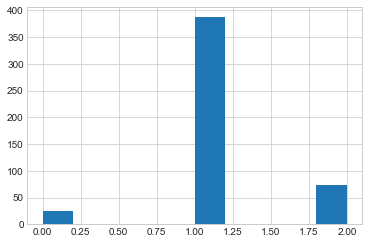

In [169]:
#data.groupby('Age').Survived.count().plot.bar()
data['Age'].hist()

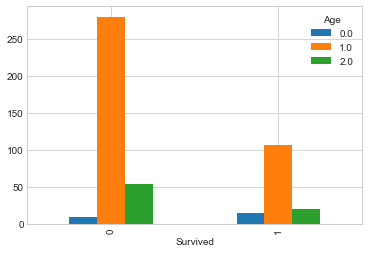

In [170]:
data.groupby('Age').Survived.value_counts().unstack(0).plot.bar()

In [171]:
child = data[data['Age'] == 0]
adult =  data[data['Age'] == 1]
middle =  data[data['Age'] == 2]
child_surv = child[child['Survived'] == 1]
adult_surv = adult[adult['Survived'] == 1]
middle_surv = middle[middle['Survived'] == 1]
print("Per of child survived ",(len(child_surv)/len(child))*100)
print("Per of adult survived ",(len(adult_surv)/len(adult))*100)
print("Per of middle age survived ",(len(middle_surv)/len(middle))*100)

Per of child survived  62.5
Per of adult survived  27.648578811369507
Per of middle age survived  27.397260273972602


In [ ]:
## FINDINGS
Children survived the most, so age is significant for survival

## Heatmap analysis

AxesSubplot(0.125,0.1925;0.62x0.62)


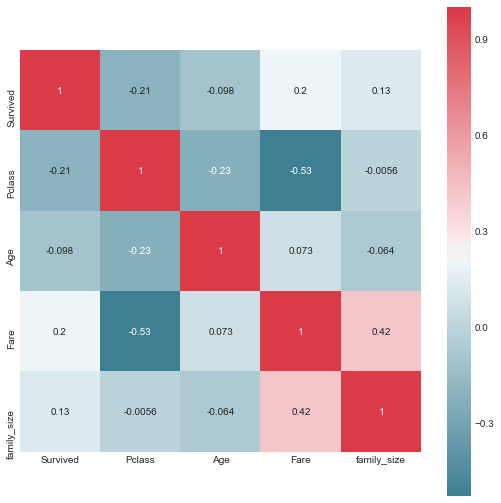

In [172]:
f,ax=plt.subplots(figsize=(9,9))
corr = data.loc[:,continous_names].corr()
print(sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),
            square =True,ax=ax,annot = True))

In [391]:
#data['Fare']data[data['Fare']==0]
#data.describe()
#data['Survived'] = data['Survived'].astype('int')
continous_names, cat_names = get_col_names()
print('-----Summary of columns')
print('Total col -',data.shape[1] )
print('continous are -', len(continous_names))
print(data[continous_names].head(1))
print('-----')
print('categorical are -', len(cat_names))
print(data[cat_names].head(1))

-----Summary of columns
Total col - 9
continous are - 5
   Survived  Pclass  Age  Fare  family_size
0         0       3  1.0   0.0            2
-----
categorical are - 4
    Sex     Ticket Embarked is_alone
0  male  A/5 21171        S        0


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


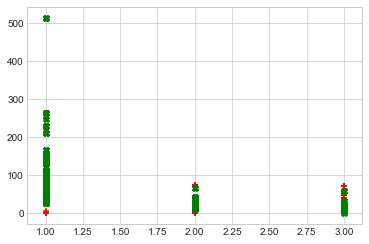

In [251]:
#lets see how is the decision boundary going to be
df0 = data[data['Survived'] == 0]
df1 = data[data['Survived'] == 1]
print(data.Fare.describe())
plt.scatter(df0['Pclass'], df0.Fare, marker='+',color='red')
plt.scatter(df1['Pclass'], df1.Fare, marker='X',color='green')

In [ ]:
data.head(2)

## lets plot some bar graphs for categorical variables

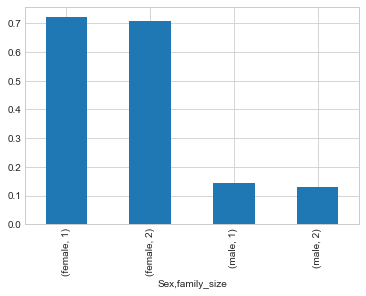

In [173]:
##Sex,family size and survival
data.groupby(['Sex','family_size'])['Survived'].mean().plot.bar()


## Insight
female survived more irrespective of family size

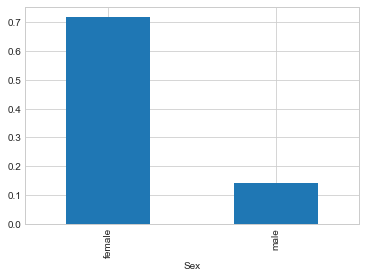

In [180]:
#Sex and survival
#Graphical
data.groupby(['Sex'])['Survived'].mean().plot.bar()

In [179]:
#mathematical
male = data[data['Sex'] == 'male']
female = data[data['Sex'] == 'female']
male_sur = male[male['Survived'] == 1]
female_sur = female[female['Survived'] == 1]
print('Total males--',len(male), 'Total females-- ',len(female))
print('No of male survivors---',len(male_sur),'No of female survivors---',len(female_sur))
print('per of male survivors---',len(male_sur)/len(male)*100,'No of female survivors---',len(female_sur)/len(female)*100)

Total males-- 357 Total females--  127
No of male survivors--- 51 No of female survivors--- 91
per of male survivors--- 14.285714285714285 No of female survivors--- 71.65354330708661


## Insight
Female survived more

In [394]:
sur =data[data['Survived'] == 1]
non_sur =data[data['Survived'] == 0]
male_surv = sur[sur['Sex'] == 'male']
female_surv = sur[sur['Sex'] == 'female']
male_non_surv = sur[sur['Sex'] == 'male']
female_non_surv = sur[sur['Sex'] == 'female']

In [181]:
data.describe()

,Survived,Pclass,Age,Fare,family_size
count,484.000000,484.000000,484.000000,484.000000,484.000000
mean,0.293388,2.628099,1.101240,0.795455,1.163223
std,0.455786,0.618985,0.436529,0.786467,0.369952
min,0.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,1.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,1.000000,1.000000
max,1.000000,3.000000,2.000000,3.000000,2.000000


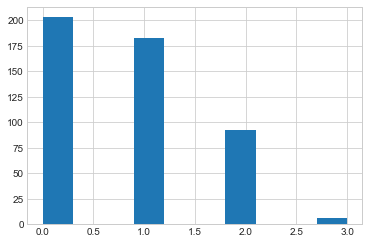

In [182]:
#Lets look at fare
data['Fare'].hist()

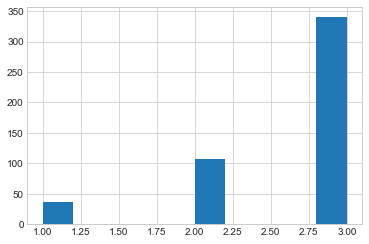

In [399]:
#we have largest number of people from pclass-3
data['Pclass'].hist()

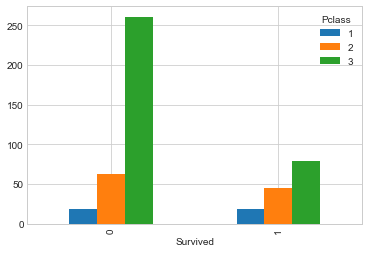

In [400]:
#Pclass and survival
#Graphical
data.groupby('Pclass').Survived.value_counts().unstack(0).plot.bar()

In [403]:
#mathematical
surv = data[data['Survived'] == 1]
surv_p1,surv_p2,surv_p3= surv[surv['Pclass'] == 1],surv[surv['Pclass'] == 2],surv[surv['Pclass'] == 3]
print('survived-----p1',len(surv_p1)/len(surv)*100,'--p2',len(surv_p2)/len(surv)*100,'--p3',len(surv_p3)/len(surv)*100)

non_surv = data[data['Survived'] == 0]
##print(non_surv[non_surv['Pclass'] == 1])
non_surv_p1,non_surv_p2,non_surv_p3= non_surv[non_surv['Pclass'] == 1],non_surv[non_surv['Pclass'] == 2],non_surv[non_surv['Pclass'] == 3]
print('non-survived ---p1',len(non_surv_p1)/len(non_surv)*100,'--p2',len(non_surv_p2)/len(non_surv)*100,'--p3',len(non_surv_p3)/len(non_surv)*100)


survived-----p1 12.676056338028168 --p2 31.690140845070424 --p3 55.633802816901415
non-survived ---p1 5.263157894736842 --p2 18.421052631578945 --p3 76.31578947368422


## Insight
out of all the classes P3 survived the most

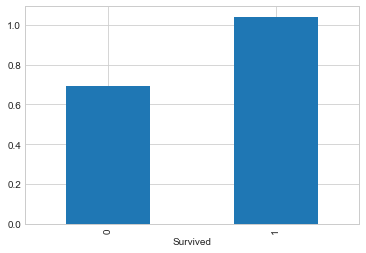

In [404]:
data.groupby('Survived').Fare.mean().plot.bar()

In [184]:
#Fare and survival
surv = data[data['Survived'] == 1]
non_surv = data[data['Survived'] == 0]
print('mean fare of non-survivors-- ',non_surv['Fare'].mean(),'\nmean fare of survivors --',surv['Fare'].mean())



mean fare of non-survivors--  0.6929824561403509 
mean fare of survivors -- 1.0422535211267605


## Insight
Looks like survivors paid more fare

## Is there any relation b/w passenger fare and survival

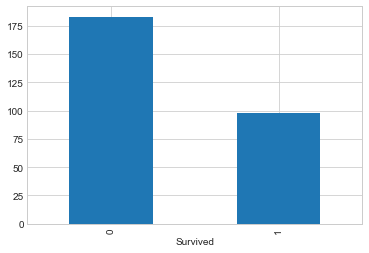

In [193]:
#get dataframe having fare > mean fare,and see how many such people who payed more fare survived
tmp = pd.DataFrame(data[data['Fare'] > data['Fare'].mean()].Survived, columns = ['Survived'])
tmp.groupby('Survived').Survived.count().plot.bar()

In [195]:
#mathematical proof
passenger_paid_more_than_avg = data[data['Fare'] >data['Fare'].mean()]
passenger_paid_less_than_avg = data[data['Fare'] < data['Fare'].mean()]
surv_passenger_paid_more_than_avg = passenger_paid_more_than_avg[passenger_paid_more_than_avg['Survived'] == 1]
non_surv_passenger_paid_more_than_avg = passenger_paid_more_than_avg[passenger_paid_more_than_avg['Survived'] == 0]
surv_passenger_paid_less_than_avg = passenger_paid_less_than_avg[passenger_paid_less_than_avg['Survived'] == 1]
print('People who paid more than avg fare and did not survived--',len(non_surv_passenger_paid_more_than_avg))
print('People who paid more than avg fare and did survived--',len(surv_passenger_paid_more_than_avg))

People who paid more than avg fare and did not survived-- 183
People who paid more than avg fare and did survived-- 98


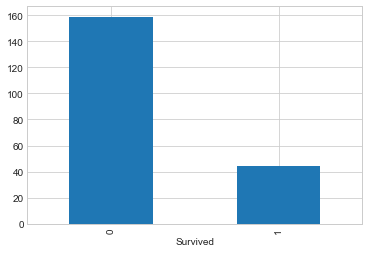

In [196]:
#get dataframe having fare < avg fare,and see how many such people who payed more fare survived
tmp = pd.DataFrame(data[data['Fare'] < data['Fare'].mean()].Survived, columns = ['Survived'])
tmp.groupby('Survived').Survived.count().plot.bar()

## Insight:
Not much of a difference,both looks same .Fare is not that significant

In [197]:
continous_names, cat_names = get_col_names()
print('-----Summary of columns')
print('Total col -',data.shape[1] )
print('continous are -', len(continous_names))
print(data[continous_names].head(1))
print('-----')
print('categorical are -', len(cat_names))
print(data[cat_names].head(1))

-----Summary of columns
Total col - 8
continous are - 5
   Survived  Pclass  Age  Fare  family_size
0         0       3  1.0   0.0            2
-----
categorical are - 3
    Sex Embarked is_alone
0  male        S        0


## Normalization

In [ ]:
#TBD

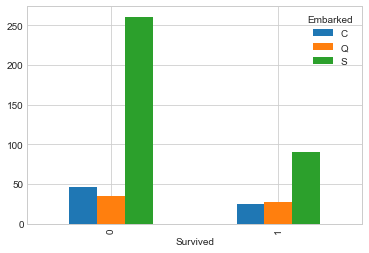

In [198]:
data.groupby('Embarked').Survived.value_counts().unstack(0).plot.bar()

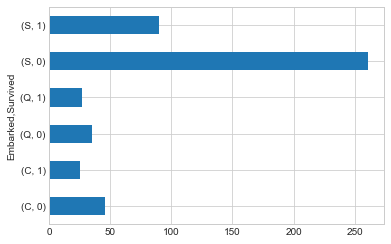

In [199]:
data.groupby('Embarked').Survived.value_counts().plot.barh()

In [206]:
#lets drop ticket
if 'Ticket' in cat_names:
    for i,dataset in enumerate(full_data):
        dataset = dataset.drop(['Ticket'], axis=1)
        if i == 0:#updae back
            data = dataset
        else:
            test = dataset
    full_data = [data,test]#full update
    cat_names.remove('Ticket')

In [208]:
data.shape

(484, 8)

In [224]:
#Categ to dummy
#full_data = [data,test]
data = full_data[0]
test = full_data[1]
for i,dataset in enumerate(full_data):
    dataset = pd.get_dummies(dataset, columns=cat_names)
    if i == 0:#updae back
        data = dataset
    else:
        test = dataset
full_data = [data,test]#full update

In [210]:
data.dtypes

Survived         int64
Pclass           int64
Age            float64
Fare           float64
family_size      int64
Sex_female       uint8
Sex_male         uint8
Embarked_C       uint8
Embarked_Q       uint8
Embarked_S       uint8
is_alone_0       uint8
is_alone_1       uint8
dtype: object

In [213]:
#Saving for future purpose
data.to_csv(processed_data_path,index=False)
#data = pd.read_csv(processed_data_path)
data.head(1),data.shape
 



(   Survived  Pclass  Age  Fare  family_size  Sex_female  Sex_male  Embarked_C  \
 0         0       3  1.0   0.0            2           0         1           0   
 
    Embarked_Q  Embarked_S  is_alone_0  is_alone_1  
 0           0           1           1           0  , (484, 12))

In [26]:
#Way 1: Directly using train_test_split

iv = data.drop(['Survived'],axis=1)
dv=data['Survived'].values
iv_train, iv_test, dv_train,dv_test = train_test_split(iv,dv, test_size = 0.2)#way 1

model = RandomForestClassifier().fit(iv_train,dv_train)
print('accuracy ' ,model.score(iv_test,dv_test))

accuracy  0.8041237113402062


C:\Users\PAT\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [6]:
#class to extend sklearn classifier
class sklearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)
    def train(self, train_iv, train_dv):
        self.clf.fit(train_iv, train_dv)#train on training data
    def predict(self, test_iv):
        return self.clf.predict(test_iv)
    def feature_importances(self,x, y):
        print(self.clf.fit(x,y).feature_importances_)
    
        

In [7]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose':0
}
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }
SEED = 0#for reprducibility
NFOLDS = 5 #set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS)

In [8]:
#call with object of respective class and initialize the parameters
rf = sklearnHelper(clf = RandomForestClassifier, seed = SEED, params = rf_params)
svc = sklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [9]:

def get_oof(clf, iv, dv):
    i = 0
    avg_score = 0
    it_score = 0
    for train_index,test_index in kf.split(range(data.shape[0])):
        iv_train, iv_test, dv_train,dv_test = iv[train_index], iv[test_index]\
                                ,dv[train_index], dv[test_index]
            
        clf.train(iv_train, dv_train)
        dv_test_pred = clf.predict(iv_test)
        it_score = sklearn.metrics.accuracy_score(dv_test, dv_test_pred)
        avg_score += it_score
        print(it_score)
    return avg_score/NFOLDS

In [48]:
iv = data.drop(['Survived'], axis =1).values #for kfolds, use arrays
dv = data['Survived'].values

print('RandomForest-------')
rand_avg_score = get_oof(rf, iv, dv)
print('Average rf score', rand_avg_score)
print('SVC-----------------')
sv_avg_score = get_oof(svc, iv, dv)
print('Average svm score', sv_avg_score)
print("Training complete")
print('%%%%%%% SVC performs better for training set' if sv_avg_score>rand_avg_score else '%%%%%%%% RF performs better for training set')

RandomForest-------
0.7628865979381443
0.8144329896907216
0.8247422680412371
0.8041237113402062
0.84375
Average rf score 0.8099871134020619
SVC-----------------
0.8041237113402062
0.8247422680412371
0.8041237113402062
0.8041237113402062
0.8645833333333334
Average svm score 0.8203393470790378
Training complete
%%%%%%% SVM performs better for training set


In [37]:
#model.feature_importances_
import plotly.graph_objs as go
import plotly.offline as py


trace = go.Scatter(y = feature_dataframe['Random Forest feature importances'].values,
                  x = feature_dataframe['features'].values,
                  mode = 'markers',
                  marker = dict(sizemode = 'diameter', sizeref = 1,size = 25,
                                color = feature_dataframe['Random Forest feature importances'].values,
                                colorscale='Portland',showscale=True),
                  text = feature_dataframe['features'].values)
layout = go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig,filename='scatter2010')

## FINDING
sex_male and sex_female are pretty important feature, lets check their corr with Survived

In [34]:
#f = pd.DataFrame(model.feature_importances_.reshape(1,-1),columns=data.drop(['Survived'],axis=1).columns.values)
cols = data.drop(['Survived'],axis=1).columns
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': model.feature_importances_})
feature_dataframe.head(1)
#data.drop(['Survived'],axis=1).columns
#model.feature_importances_.reshape(1,-1)


,features,Random Forest feature importances
0,Pclass,0.135514


In [28]:
f.values,f.columns

(array([[0.1355138 , 0.07112909, 0.14175203, 0.01517587, 0.17081297,
         0.35556635, 0.01603936, 0.01984294, 0.04913609, 0.01550014,
         0.00953137]]),
 Index(['Pclass', 'Age', 'Fare', 'family_size', 'Sex_female', 'Sex_male',
        'Embarked_C', 'Embarked_Q', 'Embarked_S', 'is_alone_0', 'is_alone_1'],
       dtype='object'))

In [29]:
model.feature_importances_

array([0.1355138 , 0.07112909, 0.14175203, 0.01517587, 0.17081297,
       0.35556635, 0.01603936, 0.01984294, 0.04913609, 0.01550014,
       0.00953137])

In [30]:
iv_train.columns

Index(['Pclass', 'Age', 'Fare', 'family_size', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'is_alone_0', 'is_alone_1'],
      dtype='object')

In [223]:
#Let's check the summary of columns
continous_names, cat_names = get_col_names()
print('-----Summary of columns')
print('Total col -',data.shape[1] )
print('continous are -', len(continous_names))
print(data[continous_names].head(1))
print('-----')
print('categorical are -', len(cat_names))
print(data[cat_names].head(1))

-----Summary of columns
Total col - 8
continous are - 5
   Survived  Pclass  Age  Fare  family_size
0         0       3  1.0   0.0            2
-----
categorical are - 3
    Sex Embarked is_alone
0  male        S        0


AxesSubplot(0.125,0.1925;0.62x0.62)


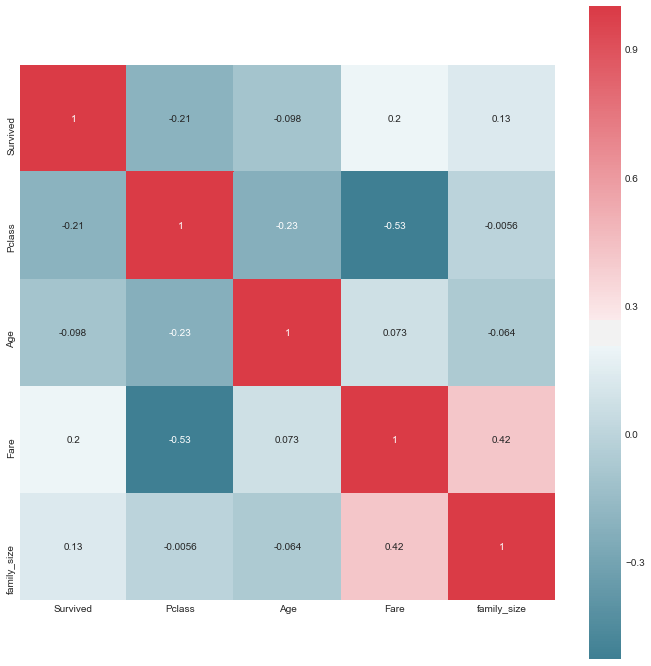

In [215]:
f,ax=plt.subplots(figsize=(12,12))
corr = data.loc[:,continous_names].corr()
print(sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),
            square =True,ax=ax,annot = True))

## FINDING
Sex_male and sex_female are negatively and positively related with Survival rate, indicating females 
survived more than men

In [216]:
iv.shape,dv.shape,test

((484, 11), (484,))

In [235]:
#Now that we know SVM fits better, we can use all of the train data to feed the model
 
iv = data.drop(['Survived'],axis=1)
dv=data['Survived'].values
iv_test = test
#iv_test = pd.read_csv(test_data_path)
model = SVC().fit(iv,dv)#Train the model using full training excel
#Let's predict for actual test data
dv_test_pred = model.predict(iv_test)
iv_test['Survived'] = dv_test_pred

#write back the results
iv_test.to_csv(submission_data_path,index=False)



C:\Users\PAT\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



,Pclass,Age,Fare,family_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,is_alone_0,is_alone_1,Survived
0,3,2.0,0.0,1,0,1,0,1,0,0,1,0
1,3,2.0,0.0,2,1,0,0,0,1,1,0,1
